In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from MultiLabel_File import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
tf.test.is_built_with_cuda() #GPU aktif mi?

ORIGINAL_DATA_PATH = "datasets/CSV_Multi_Label_Classification"
AUGMENTED_DATA_PATH = "datasets/CSV_Multi_Label_Classification_Augmented"


In [2]:
# Orijinal DataFrameleri yükle
original_train_df = utils.load_data(subset='train', base_path=ORIGINAL_DATA_PATH)
original_valid_df = utils.load_data(subset='valid', base_path=ORIGINAL_DATA_PATH)
original_test_df = utils.load_data(subset='test', base_path=ORIGINAL_DATA_PATH)

print("\nOrijinal Veri Seti Dağılımı:")
print(f"Train set: {len(original_train_df)} images")
print(f"Validation set: {len(original_valid_df)} images")
print(f"Test set: {len(original_test_df)} images")

print("\nOrijinal Eğitim Seti Etiket Dağılımı:")
print(f"Moderate Accident: {original_train_df['moderate'].sum()}")
print(f"Severe Accident: {original_train_df['severe'].sum()}")
print(f"No Accident: {original_train_df['no_accident'].sum()}")


Orijinal Veri Seti Dağılımı:
Train set: 10469 images
Validation set: 1004 images
Test set: 649 images

Orijinal Eğitim Seti Etiket Dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 259


In [3]:
# Artırılmış eğitim veri setlerini yükle
train_df = utils.load_data(subset='train', base_path=AUGMENTED_DATA_PATH)

print(f"Güncel Train set: {len(train_df)} images")

print("\nGüncel Eğitim seti etiket dağılımı:")
print(f"Moderate Accident: {train_df['moderate'].sum()}")
print(f"Severe Accident: {train_df['severe'].sum()}")
print(f"No Accident: {train_df['no_accident'].sum()}")

# TensorFlow Dataset nesneleri oluştur
train_dataset = utils.create_dataset(train_df)
valid_dataset = utils.create_dataset(original_valid_df)
test_dataset = utils.create_dataset(original_test_df)

Güncel Train set: 16944 images

Güncel Eğitim seti etiket dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 6734


In [4]:
base_model = ResNet50V2(
   include_top=False,
    weights="imagenet",#ön eğitilmiş ağırlıklar.
    input_shape=(224, 224, 3),
)
base_model.trainable = False# Bu, önceden eğitilmiş ağırlıkların eğitim sırasında değişmesini engeller

#Temel model üstğne özel katmanlar ekleniyor.
x = base_model.output
x = GlobalAveragePooling2D()(x)# Flatten yerine genelde daha stabil
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)# Çıkış katmanı (softmax çoklu sınıf sınıflandırması için)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', # Çoklu sınıf sınıflandırması için
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [5]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # Doğrulama kaybını izle
        patience=8,         # 8 epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True # En iyi ağırlıklara geri dön
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', # Doğrulama kaybı durursa
        factor=0.5,         # Öğrenme oranını %50 azalt
        patience=3,         # 3 epoch boyunca iyileşme olmazsa uygula
        min_lr=1e-7,        # En düşük learning rate oranı
        verbose=1           # LR düştüğünde çıktı versin
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_ResNet_model.h5", # En iyi modeli kaydet
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
]

In [6]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=valid_dataset,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
530/530 [==============================] - ETA: 0s - loss: 0.9732 - accuracy: 0.6431
Epoch 1: val_loss improved from inf to 0.56279, saving model to best_transfer_model.h5
530/530 [==============================] - 90s 151ms/step - loss: 0.9732 - accuracy: 0.6431 - val_loss: 0.5628 - val_accuracy: 0.7809 - lr: 1.0000e-04
Epoch 2/30
530/530 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.7931
Epoch 2: val_loss improved from 0.56279 to 0.49336, saving model to best_transfer_model.h5
530/530 [==============================] - 80s 151ms/step - loss: 0.5480 - accuracy: 0.7931 - val_loss: 0.4934 - val_accuracy: 0.8267 - lr: 1.0000e-04
Epoch 3/30
530/530 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8487
Epoch 3: val_loss improved from 0.49336 to 0.47723, saving model to best_transfer_model.h5
530/530 [==============================] - 96s 182ms/step - loss: 0.4070 - accuracy: 0.8487 - val_loss: 0.4772 - val_accuracy: 0.8416 - lr: 1

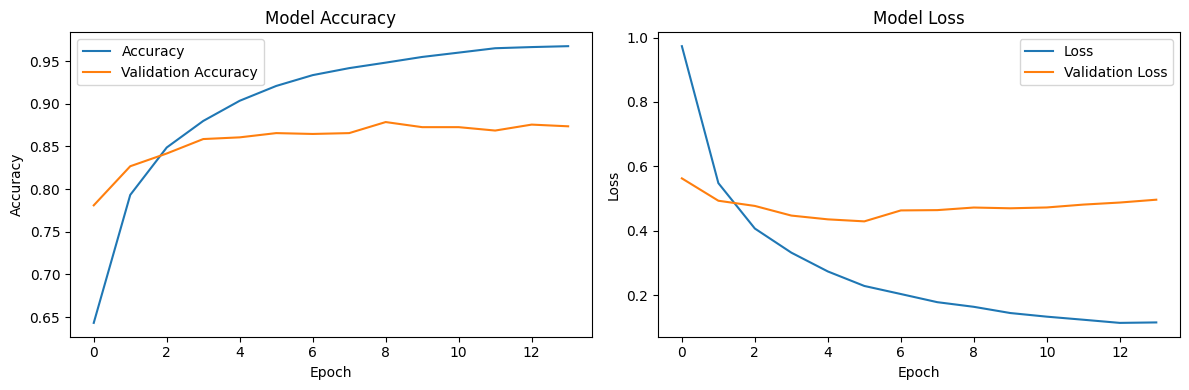

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


Test Seti Üzerinde Model Değerlendirmesi:
Accuracy: 0.8983
F1 Score: 0.8994
ROC-AUC Score: 0.9788


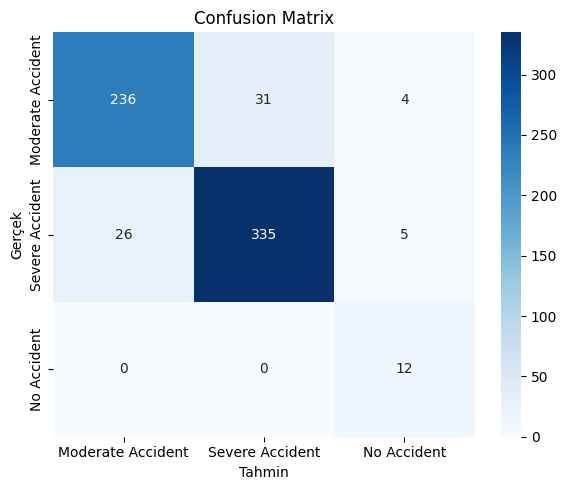


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.90      0.87      0.89       271
  Severe Accident       0.92      0.92      0.92       366
      No Accident       0.57      1.00      0.73        12

         accuracy                           0.90       649
        macro avg       0.80      0.93      0.84       649
     weighted avg       0.90      0.90      0.90       649



In [11]:
print("\nTest Seti Üzerinde Model Değerlendirmesi:")
# Kaydedilen en iyi modeli yükle
best_model = tf.keras.models.load_model("best_ResNet_model.h5")

class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(best_model, test_dataset, class_names)


Rastgele Seçilen Test Görüntülerinde Tahminleri Görselleştirme:


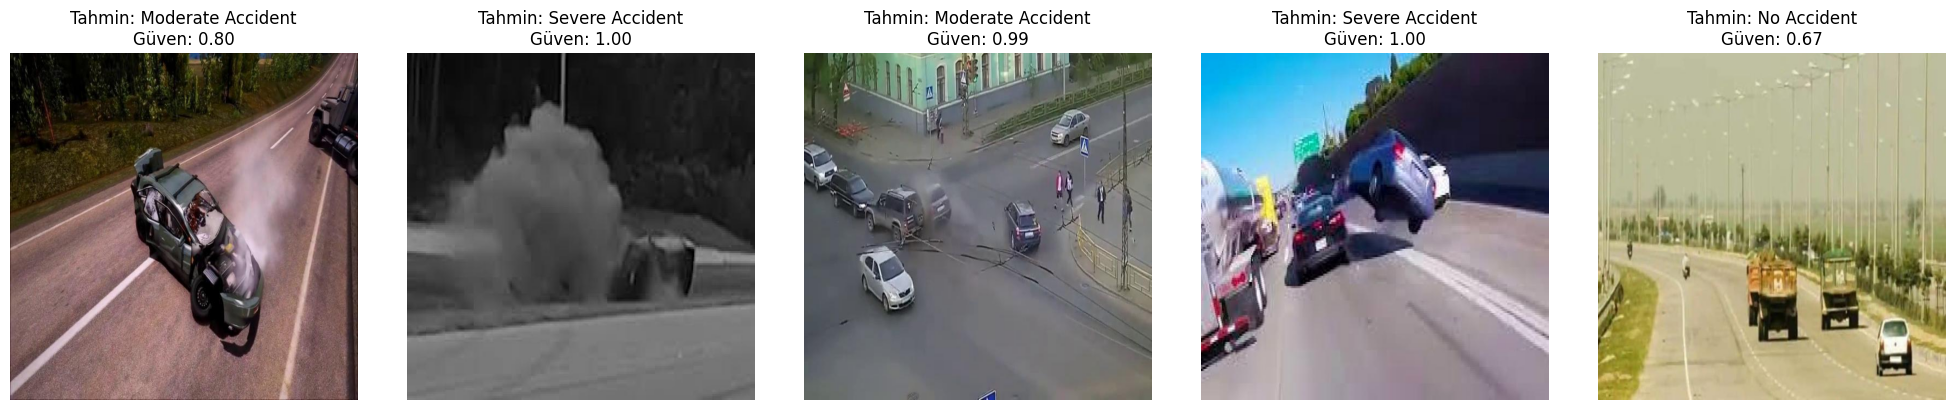

In [14]:
print("\nRastgele Seçilen Test Görüntülerinde Tahminleri Görselleştirme:")
utils.visualize_predictions(best_model, original_test_df['filename'].values, class_names=class_names, num_images=5)